# User Location Classification in Hurricane Harvey
The goal of this analysis is to evaluate methods by which users Tweeting about Hurricane Harvey may be classified as in the area or otherwise.

Data was collected with custom software which observed several Twitter streams and enhanced this information by querying the Twitter REST APIs for the network data (friends and followers) of each author. Stream volume which exceeded the capacity of the REST requests was discarded. 
* The keyword stream monitored the terms: [#harvey, #harveystorm, #hurricaneharvey, #corpuschristi]
* The GPS stream used the bounding box: [-99.9590682, 26.5486063, -93.9790001, 30.3893434]
* The collection period ran from 2017-08-26 01:32:18 until 2017-09-02 10:30:52 
* 55,605 Tweets by 33,585 unique authors were recorded

Data was coded using an interface built into the collection software by a primary coder. A secondary coder coded a sub-set of coded users for validation of the coding schema. User instances were coded by whether they 'appeared to be in the affected area'.

These notebooks access the data directly from the database using standard Django query syntax.


# Data Cleaning & Enrichment
First we get all the coding instances made by the primary and secondary coders, and check the total codings of each class. There may be multiple coding dimensions (sets of coding schema), in which case the code requires adjustment to constrain to one.

In [140]:
import pandas as pd

# Get coding instances of user objects:
account_codings = (Coding.objects
                    .filter(coding_id=1)
                    .filter(user__isnull=False)
                    .filter(data_code__data_code_id__gt=0)
                  )
account_codings_secondary = (Coding.objects
                                 .filter(coding_id=2)
                                 .filter(user__isnull=False)
                            )

# Check available coding schema:
dimensions = DataCodeDimension.objects.all()[1:]
for d in dimensions:
    print('Coding Dimension: ', d.name)
    print('Subject: ', d.coding_subject)
    print('Class Totals (primary / secondary): ')
    for code in d.datacode.all():
        print("\t {}: \t{} \t/ {}"
                .format(code.name, 
                    account_codings.filter(data_code__id=code.id).count(), 
                    account_codings_secondary.filter(data_code__id=code.id).count())
             )
print("{} Accounts coded by primary coder, {} by secondary coder.".format(account_codings.count(), account_codings_secondary.count()))
if len(dimensions) > 1: 
    print('\tNote: Totals represent sum of all codes from {} dimensions.'.format(len(dimensions)))
    print('WARNING: Code in cells below assume one dimension -- adjust to constrain.')

Coding Dimension:  Local
Subject:  user
Class Totals (primary / secondary): 
	 Unsure: 	31 	/ 5
	 Non-Witness: 	1083 	/ 94
	 Witness: 	386 	/ 52
1500 Accounts coded by primary coder, 151 by secondary coder.


We then create a dataframe of all users which have been coded by the primary coder to create the initial dataset. The subjects of the secondary coder are a subset of this set by design.

In [141]:
# Get all Users coded by primary coder:
# (exclude data_code_id=0 as this is the temporary 'to be coded' class)
users = User.objects.filter(coding_for_user__coding_id=1, 
                            coding_for_user__data_code__data_code_id__gt=0)
users_df = pd.DataFrame(list(users.values()))

# Check for missing values by column:
users_df.count()[users_df.count() != account_codings.count()].sort_values(ascending=False)

utc_offset                           920
time_zone                            920
undirected_eigenvector_centrality    890
closeness_centrality                 890
degree_centrality                    890
eigenvector_centrality               890
load_centrality                      890
betweenness_centrality               890
url                                  808
old_screen_name                       98
suspended                              0
user_network_update_observed_at        0
needs_phone_verification               0
user_followers                         0
katz_centrality                        0
is_deleted_observed                    0
is_deleted                             0
user_followers_update                  0
user_following                         0
user_following_update                  0
dtype: int64

* The centrality measures have a common value. As these values are only calculated for the largest connected component of the graph, this consistency makes sense.
* The fields time_zone, utc_offset, old_screen_name, and url are nullable.
* Twitter has deprecated the field 'needs_phone_verification', so no values were returned.
* Various 0 value fields had been added to the database schema but were not implemented at the time of collection. These can be safely dropped.

In [142]:
# Dropping empty columns
empty_cols = users_df.columns[users_df.isnull().all()]
users_df.drop(empty_cols, axis=1, inplace=True)

We can also drop columns which have a single value, as they provide no differentiation:

In [146]:
# Drop columns with only one unique value:
for col in users_df.columns:
    if len(users_df[col].value_counts()) <= 1:
        print('Dropping columns: ', col)
        users_df = users_df.drop([col], axis=1)

Dropping columns:  protected
Dropping columns:  ratio_media
Dropping columns:  user_class


## Adding Location Data
There are a number of options which can represent the ground truth location of the user.
* Location listed on a user's profile
* User Timezone (deprecated)
* Manual Coding
* Location data derived from Tweet stream
    * GPS tagged Tweets
    * Mention of location in Tweet body
    
### Parsing user-set location in profile field
The location the user sets in their profile as a string is evaluated and a locality decision made. In this instance, a location is considered 'local' if its coordinates (supplied by the Google geolocation API or parsed directly from the location string) fall within the bounding box used for geographic Twitter data collection, or if it contains the string 'houston' or 'christi' (representing the town Corpus Christi). Both of these locations fall within the bounding box, and are used here as a time-saving operation.

Note that as this field can be set manually, it is unverifiable and therefore not a perfect representation of location, even where it exists. Users may neglect to update their location after moving, and some observations were made of users setting their location to that of a disaster event as a 'show of solidarity'.

In [137]:
## This block supports manual coding of locations as local or non-local.
## It has been superceded by the next block which uses the Googlemaps API

#location_list = users_df.location.unique()
#with open('data/harvey_user_location/location_list_all_profile_locations.txt', 'w') as f:
#    for item in location_list:
#        f.write("%s\n" % item)

################
## This list then manually sorted and non-local locations removed.
## List of local locations then re-imported.
## Note this list excludes any locations containing 'Christi' or 'Houston'
## Note: if more users are coded, this list needs to be re-examined. Raise alert:
#if users_df.shape[0] != 931:
#    print('ALERT: New codings detected. Consider updating manual locality selection')
################

#with open('data/harvey_user_location/local_profile_locations_manual_check.txt', 'r') as f:
#    local_locations_list = f.read().splitlines()
    
## Create column for users with local location listed in profile
#users_df['local_profile_location_manual'] = \
#    (users_df.location.str.contains('houston|christi', case=False, regex=True) |
#    users_df.location.isin(local_locations_list))

In [7]:
import re

def parse_coordinates(string):
    '''Parse a string for coordinates'''
    reg = '[nsewNSEW]?\s?-?\d+[\.°]\s?\d+°?\s?[nsewNSEW]?'
    result = re.findall(reg, string)
    if len(result) == 2: # Coordinates detected
        for i in range(len(result)):
            # Replace middle degree symbol with decimal:
            reg_middle_degree = '(\d+)°\s?(\d+)'
            result[i] = re.sub(reg_middle_degree, r'\1.\2', result[i])
            # Remove trailing degree symbol, N and E marks:
            reg_strip = '[°neNE\s]'
            result[i] = re.sub(reg_strip, '', result[i])
            # Replace south/west with negative sign:
            reg_replace_sw = '[swSW](\d+\.\d+)|(\d+\.\d+)[swSW]'
            result[i] = re.sub(reg_replace_sw, r'-\1\2', result[i])
            # Remove double negative (where string contained eg. '-99.10w')
            result[i] = re.sub('--', '-', result[i])
        return (float(result[0]), float(result[1]))
    else:
        return False

In [8]:
import yaml
import googlemaps

def is_in_bounding_box(coords, boxes):
    '''
    Check whether coordinates fall within defined bounding box:
    Boxes are defined as their NW and SE points.
    '''
    for box in boxes:
        if coords[0] < box[0][0] and coords[0] > box[1][0]:
            if coords[1] > box[0][1] and coords[1] < box[1][1]:
                return True
    return False


def is_local(location, boxes, known_localities=[]):
    '''
    Check whether a location string falls within a set of 
    bounding boxes using Googlemaps API.
    '''
    if not location:
        return False
    # Check known localities first to save on API requests:
    for x in known_localities:
        if x in location:
            return True
    # Try and parse coordinates from string rather than API query:
    coords = parse_coordinates(location)
    # Get coords from API:
    if not coords:
        # Get API key from file:
        with open("auth.yml", 'r') as ymlfile:
            auth = yaml.load(ymlfile, Loader=yaml.BaseLoader)
        gmaps = googlemaps.Client(key=auth['apikeys']['googlemaps'])
        #########################################################
        ####### OVERRIDE API OBJECT TO PREVENT API CALLS: #######
        geocode_result = gmaps.geocode(location)
        #geocode_result = False
        #print('WARNING -- API DISABLED')
        #########################################################
        #########################################################
        if geocode_result:
            lat = geocode_result[0]['geometry']['location']['lat']
            lon = geocode_result[0]['geometry']['location']['lng']
            coords = (lat, lon)
    if coords:
        return(is_in_bounding_box(coords, boxes))
    return False

In [13]:
# Bounding boxes used for Hurricane Harvey dataset:
boxes = [[(29.1197,-99.9590682),(26.5486063,-97.5021)],
        [(30.3893434,-97.5021),(26.5486063,-93.9790001)]]
# Don't need to look these up (save on API requests)
known_localities = ['houston', 'christi']

# Get list of locations in profiles:
users_df["location"] = users_df["location"].str.lower().str.strip()
location_list = users_df.location.dropna().unique()

# Create sublist of local/non-local locations (non-local only for manual verification)
print("Running is_local() for {} strings...".format(len(location_list)))
local_location_list = [loc for loc in location_list if is_local(loc, boxes, known_localities)]
non_local_location_list = [loc for loc in location_list if loc not in local_location_list]

# Create column for users with local location listed in profile
users_df['local_profile_location'] = users_df.location.str.lower().isin(local_location_list)

# Write lists to file to save calling API on kernel restart:
with open('data/harvey_user_location/location_list_from_api_local.txt', 'w') as f:
    for item in local_location_list:
        f.write("%s\n" % item)
with open('data/harvey_user_location/location_list_from_api_non_local.txt', 'w') as f:
    for item in non_local_location_list:
        f.write("%s\n" % item)

In [21]:
# Use cached locations instead of querying API:
#users_df["location"] = users_df["location"].str.lower().str.strip()
#local_location_list_cached = []
#with open('data/harvey_user_location/location_list_from_api_local.txt', 'r') as f:
#    for line in f:
#        local_location_list_cached.append(line.rstrip('\n'))
#users_df['local_profile_location'] = users_df.location.str.lower().isin(local_location_list)

### Timezone Field
Timezone data provided by Twitter when capturing the user objects is less specific than other methods, but may be useful as a supplementary source.
As this data field has been deprecated by Twitter, it will not be available in new data sets.

In [26]:
# View most prevalent time zones:
print(users_df['time_zone'].value_counts().head())

# Create column for profiles in relevant time zone (chosen manually):
relevant_timezone = 'Central Time (US & Canada)'
users_df['local_timezone'] = users_df.time_zone == relevant_timezone
users_df = users_df.drop(['time_zone', 'utc_offset'], axis=1)

Central Time (US & Canada)     341
Eastern Time (US & Canada)     197
Pacific Time (US & Canada)     177
Mountain Time (US & Canada)     37
Quito                           25
Name: time_zone, dtype: int64


### Manual Coding
Accounts were manually coded as 'local' or 'non-local'.

Coders were shown the user account details as well as the Twitter stream of the user. The coders were instructed to determine whether the user account was in an area affected by the hurricane at any point during the data collection period. Therefore, the term 'local' may be misleading to the reader, as the definition given to the coders will include anyone visiting the area as, for example, a responder or aid worker. This larger set of 'on the ground' users is a more useful target for classification.

In [27]:
# Create column to represent manual coding:
users_df['coded_as'] = \
    users_df['screen_name'].apply(lambda x: account_codings.get(user__screen_name = x).data_code.name)

# Convert to one-hot encoding
users_df['coded_as_witness'] = users_df['coded_as'] == 'Witness'
users_df['coded_as_non_witness'] = users_df['coded_as'] == 'Non-Witness'

# Remove original column:
users_df = users_df.drop(['coded_as'], axis=1)

The 'Unsure' code is represented as `False` values in both the `coded_as_witness` and `coded_as_non_witness` columns. If the 'Unsure' rows are removed, we can also remove the `coded_as_non_witness` column (which is now represented as `False` in the `coded_as_witness` column).
<br /><br />

### GPS from Tweet stream
While the Tweets detected by the system may not contain GPS data, the author may have made other GPS-enabled Tweets during the collection period from which we can infer location. We create a column representing whether the user made any geolocated Tweets within the bounding box during the collection period.

In [28]:
# Check whether any of a user's Tweets fall within the bounding box and update column:
# This will take several minutes to run

users_df['tweet_from_locality'] = False
users = users_df.screen_name.tolist()

for i in range(len(users)):
    if i%100 == 0:
        print('Progress: {} of {}: {}'.format(i, len(users)))
    try:
        geo_tweets = User.objects.get(screen_name=u).tweet.filter(coordinates_lat__isnull=False)
    except:
        print('Error with user: ', u)
        continue
    for tweet in geo_tweets:
        coords = (tweet.coordinates_lat, tweet.coordinates_lon)
        if is_in_bounding_box(coords, boxes):
            users_df.loc[users_df['screen_name'] == u, 'tweet_from_locality'] = True
            break

1500
User 10 of 1500: ChristiWilliams
User 20 of 1500: OliviaFett
User 30 of 1500: UHhousing
User 40 of 1500: SmallTownDicks
User 50 of 1500: WmBrockschmidt
User 60 of 1500: marc_ahx
User 70 of 1500: TamaraChanel
User 80 of 1500: VotersDemand
User 90 of 1500: MC_Halo687
User 100 of 1500: TheBlazeKari
User 110 of 1500: Ambersallin
User 120 of 1500: Hamal
User 130 of 1500: JMarkMcGinnis
User 140 of 1500: deleon_sarita
User 150 of 1500: meaneyreport
User 160 of 1500: touchawe
User 170 of 1500: Devil_dog_71
User 180 of 1500: 2020Jobs
User 190 of 1500: stevenmaislin
User 200 of 1500: bquentin3
Error with user:  TCAIS
User 210 of 1500: Oscarluism_
User 220 of 1500: hillarybeth
Error with user:  SEFLCareers
User 230 of 1500: homesteadraised
User 240 of 1500: ArmyBtownAD
User 250 of 1500: MagentaMelee
User 260 of 1500: thepaigelewis
User 270 of 1500: meVschristina
User 280 of 1500: AvvBrosisky
User 290 of 1500: JeremiahWheele1
User 300 of 1500: KurtLKrieger
User 310 of 1500: TrueDumbBlonde
Use

###  Temporary Export
The dataframe is exported to a csv file before further manipulation (and column dropping) to avoid repeating the expensive tasks above.

In [135]:
import pandas as pd
path = 'data/harvey_user_location/df_users_temp.csv'

# Sanitise description field:
users_df["description"] = users_df["description"].str.replace("\r", " ")
users_df.to_csv(path)

In [136]:
# Re-import and check rows match:
orig_shape = users_df.shape
users_df_temp = pd.read_csv(path, index_col=0)
if users_df_temp.shape == orig_shape:
    users_df = users_df_temp
else:
    print("Shape mis-match. Check string sanitisation")

## Data Enrichment
New features are synthesised from existing data.


Columns are added which represent the age of the user account (at the time of original collection) and at which point during the event the account was first detected by the stream.

In [147]:
# Create columns to represent age of account at time of detection, and how soon
# after the beginning of the event that the account was first detected.

from datetime import datetime

# Calculate whole days between two dates:
def get_age_in_days(date_str, anchor_date):
    date_str = str(date_str) # In case date_str is already a datetime obj
    if date_str[-3:-2] == ":":
        date_str = date_str[:-3] + date_str[-2:]
    try:
        datetime_object = datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S%z')
    except:
        datetime_object = datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S.%f%z')
    return abs((anchor_date - datetime_object).days)

    
# Get dates of event:
e = Event.objects.all()[0]
end = max(e.time_end, e.kw_stream_end, e.gps_stream_end)
start = min(e.time_start, e.kw_stream_start, e.gps_stream_start)


# Create column for age of account at end of data collection period:
users_df['account_age'] = users_df['created_at'].apply(get_age_in_days, args=(end,))

# Create column for how early from beginning of event account was first detected:
users_df['day_of_detection'] = users_df['added_at'].apply(get_age_in_days, args=(start,))

An error in data collection allowed some `in_degree` and `out_degree` values to become negative. These are adjusted to 0. 

Note: It is possible that other entries have values one lower than what they should be.

In [118]:
# Fix negative values in in_degree and out_degree: an error from data collection:
users_df.loc[users_df['in_degree'] < 0, 'in_degree'] = 0
users_df.loc[users_df['out_degree'] < 0, 'out_degree'] = 0

## Feature Encoding
Qualitative columns are converted into formats interpretable by a model.

In [148]:
# Create column to represent length of profile description:
users_df['description_length'] = users_df.description.str.len()
#users_df = users_df.drop(['description_length'], axis=1)

# Profile language is English:
users_df['lang_is_en'] = users_df['lang'] == 'en'
users_df = users_df.drop(['lang'], axis=1)

# translator_type exists:
users_df['has_translator_type'] = users_df['translator_type'] != 'none'
users_df = users_df.drop(['translator_type'], axis=1)

# Url in profile:
users_df['has_url'] = users_df['url'].notnull()

# User has changed screen_name during collection period:
users_df['changed_screen_name'] = users_df['old_screen_name'].notnull()

We check for columns which should be represented categorically by counting the unique values in each column (under the assumption that categorical variables will have fewer than 20 unique values):

In [105]:
# Check columns for categorical candidates:
for col in users_df.columns:
    if len(users_df[col].value_counts()) <= 20:
        if len(users_df[col].unique()) == 2 and 0 in users_df[col].unique() and 1 in users_df[col].unique():
            continue # Already encoded as True/False
        print(col)
        print(users_df[col].unique(),'\n')

data_source
[1 3] 

day_of_detection
[3 5 1 2 6 4 7 8] 



`day_of_detection` is an ordinal feature and is therefore untouched.

`data_source` is a categorical feature, so we re-encode it as a binary value. Here, the values of 1 and 3 are arbitrary (the 2 value was not implemented in the collection process).

In [107]:
# Encoding categorical columns as one-hot:
# data_source==1 is not encoded as we only need n-1 columns to represent n categories.
users_df['is_data_source_3'] = users_df['data_source'] == 3.
users_df = users_df.drop(['data_source'], axis=1)

True/False columns are converted to 1/0 values for model compatibility

In [113]:
# Convert True/False columns to 1/0
print('Converting columns from boolean to binary:\n')
for col in users_df.columns:
    if (len(users_df[col].value_counts()) == 2 and 
            True in users_df[col].values and 
            False in users_df[col].values):
        print(col)
        users_df[col] = users_df[col].astype(int)

Converting columns from boolean to binary:

default_profile
default_profile_image
geo_enabled
has_extended_profile
is_translation_enabled
verified
local_profile_location
local_timezone
coded_as_witness
coded_as_non_witness
tweet_from_locality
lang_is_en
has_translator_type
has_url
changed_screen_name
is_data_source_3


## Export to File

In [124]:
import pandas as pd

path = 'data/harvey_user_location/df_users.csv'

users_df.to_csv(path)

# Re-import and check rows match:
orig_shape = users_df.shape
users_df_temp = pd.read_csv(path, index_col=0)
if users_df_temp.shape == orig_shape:
    users_df = users_df_temp
    print('Dataframe exported to CSV.')
    print(users_df.shape)
else:
    print("Shape mis-match. Check string sanitisation")


Dataframe exported to CSV.
(1500, 45)


# Testing Community Detection Data

<img src="./data/harvey_user_location/img/harvey-network-structure.png" alt="network-structure" style="width: 600px;"/>

A visual inspection of the follower/friend network of detected users (pictured above) shows a clear community structure. This suggests that there are certain user features that influence the propensity for a user to follow another user with similar features. These may be features which we have observed and recorded, or other features which we cannot predict. This can be tested by using community detection algorithms to partition the nodes of the graph into these communities, and then comparing these partitions to features with which they may be associated. Primarily, we are interested in whether these communities are related to whether a user is a 'witness' or not, as per our manual coding. If this is the case, the community metrics can be a useful feature in our models.

The image below shows a representation of the same network structure, where only the 1500 coded nodes are displayed in colours which represent their codes. The general grouping of orange nodes towards one section of the graph which corresponds with a community cluster shown in the original graph structure suggests that this community contains a greater proportion of witness nodes and therefore is a dependent feature. A preliminary hypothesis is that local users are more likely to follow one another (thus forming this community) and are also more likely to be witnesses. If true, this community could accurately predict which users are local and therefore, more likely to be witnesses.

<img src="./data/harvey_user_location/img/harvey-network-structure-coded.png" alt="network-structure-coded" style="width: 600px;"/>

The following image shows the output of a community detection algorithm which has partitioned the graph. In this example, the pink community appears to represent the witness group shown in the previous image.

<img src="./data/harvey_user_location/img/harvey-network-structure-community.png" alt="network-structure-community" style="width: 600px;"/>

## Evaluating Community Algorithms
In the following section, the original dataframe is enhanced with modularity metrics. These are features which are calculated based upon the graph structure of the user friend/follower network. There are a number of community detection algorithms, so a set of these have been calculated to be tested and compared for association to the target (witness) class.

Community metrics were calculated using the `networkx` implementations of `greedy_modularity_communities`, `label_propagation_communities`, `asyn_lpa_communities`, `asyn_fluidc` and `community_louvain` from the `community` package. These were performed in a separate script for the sake of testing and will ideally be calculated by the data collection software at the end of the collection process in future iterations.

The graph includes all detected users (i.e. not their followers/friends unless they were also detected as authors) for a total of 31,496 nodes and 99,602 edges. Community detection was performed on subgraph representing the largest connected component of 17,958 nodes and 75,203 edges. 

As most algorithms require an undirected graph, the direction of relationships was ignored.

Communities are labelled as numbers according to their ranking in size (where 0 is the largest), thus the labels have some level of ordinality.

In [35]:
import networkx as nx

def get_graph_object():
    EVENT_NAME = Event.objects.all()[0].name.replace(' ', '')
    FILENAME = 'network_data_{}_v1.gexf'.format(EVENT_NAME)
    DIR = './data/harvey_user_location/'
    try:
        # Load cached file if available
        G = nx.read_gexf(DIR + FILENAME)
        print('Importing existing graph object...')
    except:
        print('Creating new graph object...')
        classed_users = User.objects.filter(user_class__gte=1)
        edges = Relo.objects.filter(target_user__in=classed_users, source_user__in=classed_users, end_observed_at=None)
        G=nx.DiGraph()
        for node in classed_users:
            try:
                user_code = node.coding_for_user.filter(coding_id=1).exclude(data_code__name='To Be Coded')[0].data_code.name
            except:
                user_code = ''
            G.add_node(node.screen_name, user_class=node.user_class, user_code=user_code)
        edge_list = [(edge.source_user.screen_name, edge.target_user.screen_name) for edge in edges]
        G.add_edges_from(edge_list)
        #for relo in relevant_relos:
        #    G.add_edge(relo.source_user.screen_name, relo.target_user.screen_name)
        nx.write_gexf(G, DIR + FILENAME, prettyprint=True)
        G = nx.read_gexf(DIR + FILENAME)
    return G

In [32]:
# Modularity:   https://scholar.google.com/scholar?q=Finding+community+structure+in+very+large+networks
# Label Prop:   https://neo4j.com/docs/graph-algorithms/current/algorithms/label-propagation/#algorithms-label-propagation-sample
# Louvain:      https://github.com/taynaud/python-louvain/blob/master/docs/index.rst

import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities, label_propagation_communities, asyn_lpa_communities, asyn_fluidc, girvan_newman
import community as community_louvain
from collections import Counter

def calc_community_metrics(G=None):
    EVENT_NAME = Event.objects.all()[0].name.replace(' ', '')
    DIR = './data/harvey_user_location/'
    FILENAME_COMM = 'network_data_{}_v2.gexf'.format(EVENT_NAME)
    
    FLIUD_COMMUNITIES_NUMBER = 8
    RETURN_GIANT_COMPONENT = True # Only save giant component to graph objects

    try:
        # Load cached file if available
        G = nx.read_gexf(DIR + FILENAME_COMM)
        print('Importing existing community graph object...')
    except:
        print('Calculating community metrics...')
        if not G:
            G = get_graph_object()
        print('Original graph has {} nodes and {} edges.'.format(len(G), G.number_of_edges()))
        
        # Create undirected graph (required for community detection):
        H = nx.Graph(G)

        # Get largest component
        Hcc = max(nx.connected_components(H), key=len)
        H0 = H.subgraph(Hcc)
        print('Largest component has {} nodes and {} edges.'.format(len(H0), H0.number_of_edges()))

        # Discard other components:
        if RETURN_GIANT_COMPONENT:
            G = G.subgraph(Hcc)

        # Get communities
        print('Calculating c_modularity...')
        c_modularity = list(greedy_modularity_communities(H0))
        print('Calculating c_label_prop...')
        c_label_prop = list(label_propagation_communities(H0))
        c_label_prop = sorted(c_label_prop, key=len, reverse=True)
        print('Calculating c_label_prop_asyn...')
        c_label_prop_asyn = list(asyn_lpa_communities(H0))
        c_label_prop_asyn = sorted(c_label_prop_asyn, key=len, reverse=True)
        print('Calculating c_fluid...')
        c_fluid = list(asyn_fluidc(H0, FLIUD_COMMUNITIES_NUMBER))
        c_fluid = sorted(c_fluid, key=len, reverse=True)
        # TOO SLOW:
        # print('Calculating c_girvan_newman...')
        # c_girvan_newman = list(girvan_newman(H0))

        community_output_dict = {'c_modularity': c_modularity,
                                    'c_label_prop': c_label_prop,
                                    'c_label_prop_asyn': c_label_prop_asyn,
                                    'c_fluid': c_fluid,
                                    # 'c_girvan_newman': c_girvan_newman
                                    }

        print('Adding data as node attributes...')
        # Add communities to node attributes:
        for key in community_output_dict:
            community_dict = {}
            for i, c in enumerate(community_output_dict[key]):
                for name in c:
                    community_dict[name] = i
            nx.set_node_attributes(G, community_dict, key)

        # Repeat for louvain algorithm.
        print('Calculating c_louvain...')
        partition = community_louvain.best_partition(H0)
        # Reset community indices by size
        counter = Counter(partition.values())
        ranking = sorted(counter, key=counter.get, reverse=True)
        partition_sorted = {k: ranking.index(v) for k, v in partition.items()}
        # Add to node attribute
        print('Adding data to node attribute...')
        nx.set_node_attributes(G, partition_sorted, 'c_louvain')

        print('Writing to file...')
        nx.write_gexf(G, DIR + FILENAME_COMM, prettyprint=True)
        
    return G

In [34]:
import pandas as pd

G = calc_community_metrics()
nodes = G.nodes(data=True)
df_comm = pd.DataFrame.from_dict(dict(nodes), orient='index')
df_comm = df_comm.drop(['user_class', 'user_code', 'label'], axis=1)
#df_comm = df_comm.reset_index(drop=True)
df_comm.head()

Calculating community metrics...
Importing existing graph object...
Original graph has 31931 nodes and 101096 edges.
Largest component has 18409 nodes and 76341 edges.
Calculating c_modularity...
Calculating c_label_prop...
Calculating c_label_prop_asyn...
Calculating c_fluid...
Adding data as node attributes...
Calculating c_louvain...
Adding data to node attribute...
Writing to file...


,c_modularity,c_label_prop,c_label_prop_asyn,c_fluid,c_louvain
0044Tamil,2,4,785,1,7
007rogerbmoore,3,0,854,7,1
01fmoreira,3,0,0,0,1
0KTOBR,5,2,1,4,0
0x41_0x48,241,885,1083,2,0


In [36]:
# Open original Dataframe
import pandas as pd

path = 'data/harvey_user_location/df_users.csv'

users_df = pd.read_csv(path, index_col=0)
users_df.shape

(1500, 45)

In [37]:
# Create list of community algorithm column names
comm_cols = list(df_comm.columns)

# Merge dataframes
users_df = pd.merge(left=users_df, right=df_comm, how='left', left_on='screen_name', right_index=True)

users_df.head()

,added_at,betweenness_centrality,closeness_centrality,created_at,default_profile,default_profile_image,degree_centrality,description,eigenvector_centrality,favourites_count,...,has_url,changed_screen_name,account_age,day_of_detection,is_data_source_3,c_modularity,c_label_prop,c_label_prop_asyn,c_fluid,c_louvain
0,2017-08-28 20:42:59.273657+00:00,0.000043,0.135798,2013-03-01 19:23:11+00:00,0,0,0.000304,If You Want To Live A Happy Life ❇ change your...,3.905631e-07,2030,...,0,0,1645,3,0,3.0,0.0,4.0,4.0,6.0
1,2017-08-30 13:58:20.296918+00:00,0.000015,0.122066,2014-01-20 00:34:57+00:00,1,0,0.000243,Employee Giving PM @Microsoft.A daydreamer w/ ...,1.785776e-07,1015,...,1,0,1321,5,0,5.0,0.0,1750.0,3.0,4.0
2,2017-08-26 19:51:45.107222+00:00,0.000000,0.077120,2012-07-24 13:47:47+00:00,0,0,0.000061,Making an impact isn’t something reserved for ...,8.518251e-14,12,...,1,0,1865,1,1,4.0,697.0,767.0,6.0,4.0
3,2017-08-26 11:13:05.769123+00:00,0.000383,0.167070,2010-12-16 17:30:04+00:00,0,0,0.000668,Eyeing global entropy through a timeline windo...,4.315565e-05,347,...,1,0,2451,1,0,2.0,0.0,0.0,3.0,1.0
4,2017-08-26 14:19:23.604361+00:00,NaN,NaN,2009-04-24 12:08:14+00:00,0,0,NaN,Producer. Show Control Designer. Project Coord...,NaN,25,...,0,0,3052,1,0,NaN,NaN,NaN,NaN,NaN


As chi-square tests are typically recommended to require contingency tables with values of at least 5, the small communities are discarded (also, some algorithms create many communities of 1-2 members, which will not be useful in generalisation of the model).

TODO: This only elimanates cells where the observed value is less than 5, this rule should also be applied to expected value cells.

In [38]:
# Ignore small communities where observed cases are too low (required for chi-square tests)
MIN_COMMUNITY_SIZE = 5

for col in comm_cols:
    s = users_df[col].value_counts()
    #s = users_df.loc[users_df['coded_as_witness']==1, col].value_counts()
    users_df.loc[~users_df[col].isin(s.index[s >= MIN_COMMUNITY_SIZE]), col] = np.NaN

As a preliminary visual investigation into the relationship between community and code, we can check the proportion of nodes within a community that are coded as positive cases (witnesses). In an independent case, we would expect these ratios to be similar, and reflect the overall ratio of cases, which is:
$$\frac{386}{1500} = 0.257$$
This is shown as a dotted line on the plots below.

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]

# NOTE: required input is a list of series, not dataframes
def plot_dfs_as_bar(df_list, axhline=None):
    if len(df_list) == 1:
        df_list[0].plot(kind='bar', title=df_list[0].name, colormap='Spectral', rot=45)
        return
    ncol = 2
    nrow = int((len(df_list)+1)/2)
    fig, axs = plt.subplots(nrow,ncol)
    fig.tight_layout(pad=4.0)
    if len(df_list) % 2 != 0:
        fig.delaxes(axs[nrow-1,1])
    count=0
    for r in range(nrow):
        for c in range(ncol):
            if count < len(df_list): # Handle odd length
                if len(df_list) > 2:
                    df_list[count].plot(kind='bar', ax=axs[r,c], title=df_list[count].name, colormap='Spectral', rot=45)
                else:
                    df_list[count].plot(kind='bar', ax=axs[c], title=df_list[count].name, colormap='Spectral', rot=45)
                #axs[r,c].text(.5, .9, df_list[count].name, horizontalalignment='center', transform=axs[r,c].transAxes, bbox=dict(facecolor='red', alpha=0.5))
                if axhline:
                    axs[r,c].axhline(y=axhline, color='b', linestyle='dotted', lw=2)
                count += 1

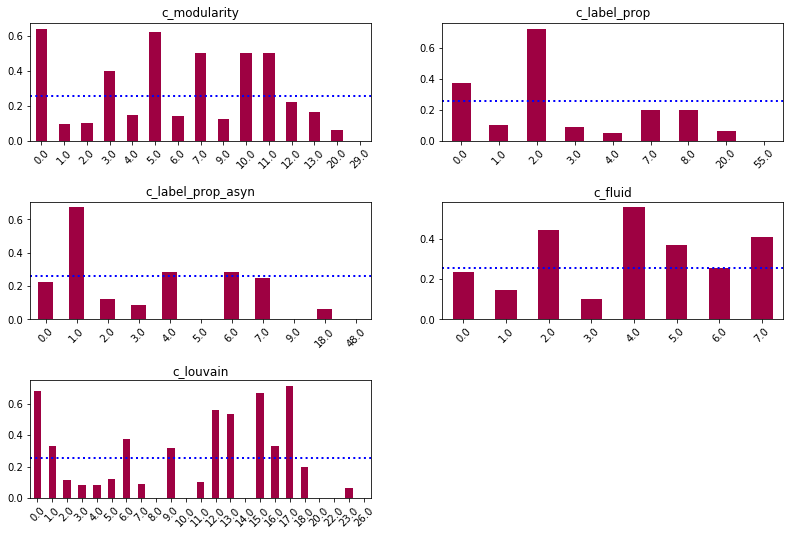

In [40]:
# Create dataframe for ratio of positive cases per community class, for each community algorithm
df_list = [users_df.loc[users_df['coded_as_witness']==1, col].dropna().value_counts() / 
               users_df[col].dropna().value_counts() 
               for col in comm_cols]

# Expected proportion of positive cases given independence:
exp_pos_proportion = users_df['coded_as_witness'].value_counts()[1] / users_df.shape[0]

plot_dfs_as_bar(df_list, exp_pos_proportion)

From inspecting the graphs above, there appears to be a disproportionate amount of positive cases in certain communities, suggesting some association between community (as detected by a given algorithm) and the classification. Therefore, it is likely that including these metrics will increase the information available to the predictive models.

The charts shown above suggest that the highest proportion of positive classes appear in the largest, or second-largest communities (as the labels have been ranked in order of size). This is significant -- a model cannot be trained on community label as a feature, as the labels are qualitative and will be different each time an algorithm runs on a network. Therefore these features cannot generalise to new datasets. The feature that is supplied must therefore be something which is generalisable; in this case, the ranking of the community by size my be appropriate (for example, a feature which represents whether a user is in the largest detected community). Alternatively, communities may exhibit different characteristics such as connectedness. This will be explored later. The higher proportions seen in some of the later communities are less relevant as these are of a much smaller size. Thus the high proportions are 'easier' to achieve, and as smaller communities are more likely to represent unique cases, they are less likely to generalise.

The next steps in the analyis of the validity of this approach is the calculate whether the disparities observed above are statistically significant. That is, whether these associations could have been observed by chance.

Formally, for each community detection algorithm, we are testing the hypotheses:
$$H_0: \text{There is no association between the community label and witness label}$$
$$H_A: \text{There is an association between the community label and witness label}$$

A chi-squre analysis is performed on the output of each detection algorithm with the target class. Note that communities with a size below 5 are removed as per the recommendation for chi-square analysis.

In [41]:
import scipy.stats as scs

def chi_square_of_df_cols(df, col1, col2):
    confusion_matrix = pd.crosstab(df[col2], df[col1])
    # Remove rows where observed cases are too low -- TODO: should also check expected values are > 4
    confusion_matrix = confusion_matrix.loc[(confusion_matrix[0] > 4) & (confusion_matrix[1] > 4)]
    return scs.chi2_contingency(confusion_matrix)

y_col = 'coded_as_witness'
data = [[col] + list(chi_square_of_df_cols(users_df, y_col, col)[:2]) for col in comm_cols]

chi2a_df = pd.DataFrame(data=data, columns=['feature', 'chi-square-a', 'p-val'])
#chi2a_df.plot(kind='bar', y='chi2', x='feature', rot=45)
chi2a_df

,feature,chi-square-a,p-val
0,c_modularity,204.309918,2.294331e-41
1,c_label_prop,76.213552,2.821223e-17
2,c_label_prop_asyn,125.941074,4.489969e-28
3,c_fluid,91.635465,5.707362e-17
4,c_louvain,192.251301,1.391196e-36


For all features, the analysis produced a significant $\chi^2$ value, well beyond our $\alpha=0.05$. Therefore we can reject the null hypothesis and accept that the alternative: there is an association between community and witness status.

In the following cells, a number of other measures of association are tested, including the `sklearn` implementation of chi-square.

We are now interested in selecting the community algorithm which is most useful in class prediction.

In [ ]:
from sklearn.feature_selection import chi2

temp_df = users_df[comm_cols + ['coded_as_witness']].dropna()

X = temp_df[comm_cols]
y = temp_df['coded_as_witness']

chi2b_df = pd.DataFrame(data={'feature': comm_cols, 'chi-square-b': chi2(X,y)[0], 'p-val': chi2(X,y)[1]})
#chi2b_df.plot(kind='bar', y='chi2', x='feature', rot=45)
chi2b_df

In [ ]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = scs.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

# Drop na values from y col
temp_df = users_df[comm_cols + ['coded_as_witness']].dropna()
y = temp_df['coded_as_witness']

data = [(col, cramers_v(temp_df[col],y)) for col in comm_cols]
cramers_df = pd.DataFrame(data=data, columns=['feature', 'cramers_v'])
#cramers_df.plot(kind='bar', x='feature', rot=45)
cramers_df

In [ ]:
import math
from collections import Counter

def conditional_entropy(x, y, log_base: float = math.e):
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x, y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0.0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y / p_xy, log_base)
    return entropy

def theils_u(x, y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = scs.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x
    
# Drop na values from y col
temp_df = users_df[comm_cols + ['coded_as_witness']].dropna()
y = temp_df['coded_as_witness']

#data = [(col, theils_u(temp_df[col],y)) for col in community_cols]
data = [(col, theils_u(y, temp_df[col])) for col in comm_cols]
theils_df = pd.DataFrame(data=data, columns=['feature', 'thiels_u'])
#theils_df.plot(kind='bar', x='feature', rot=45)
theils_df


In [ ]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

X = users_df[comm_cols]
y = users_df['coded_as_witness']
for col in comm_cols:
    y = y.loc[~X[col].isna()]
    X = X.loc[~X[col].isna()]

##tree = DecisionTreeRegressor().fit(X, y)
#tree = DecisionTreeClassifier().fit(X, y)
tree = RandomForestClassifier().fit(X, y)

rf_df = pd.DataFrame(zip(comm_cols, tree.feature_importances_), 
               columns =['feature', 'importance']) 

#rf_df.plot(kind='bar', x='feature', rot=45)
rf_df

In [ ]:
df_list = [chi2a_df, chi2b_df, cramers_df, theils_df, rf_df]
indices = chi2a_df['feature'].values
df_list = [x.set_index('feature').iloc[:,0] for x in df_list]

plot_dfs_as_bar(df_list)